In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

In [3]:
# Datensatz einlesen
original_dms_data = pd.read_csv('/Users/liza/Desktop/Bioinfo Project/DMS_data/GFP_AEQVI_Sarkisyan_2016.csv')
# split first column of df into multiple columns
original_dms_data_col = original_dms_data
only_mutants = original_dms_data["mutant"].to_frame()
original_dms_data_col[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15']] = original_dms_data_col['mutant'].str.split(':', 15, expand=True)

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_2045/1912877112.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  original_dms_data_col[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15']] = original_dms_data_col['mutant'].str.split(':', 15, expand=True)


In [4]:
# zählen wieviele Mutationen jede Sequenz hat
list_mut_count_in_progress = []
for i in range(len(original_dms_data['mutant'])):
    list_mut_count_in_progress.append(original_dms_data['mutant'].iloc[i].count(':'))
list_mut_count_prae = np.array(list_mut_count_in_progress)
list_mut_count = (list_mut_count_prae + 1)
df_mutation_counts = pd.DataFrame(list_mut_count)

In [5]:
#zusammenfügen
working_dataframe_prae = pd.concat([original_dms_data_col, df_mutation_counts], axis="columns")
#alle Spalten löschen die stören
working_dataframe = working_dataframe_prae.drop(['mutant', 'mutated_sequence', 'DMS_score_bin'], axis=1)
working_dataframe.rename(columns={working_dataframe.columns[16]: 'mut_count'}, inplace=True)
working_dataframe.head()

,DMS_score,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m14,m15,mut_count
0,1.301030,K3R,V55A,Q94R,A110T,D117G,M153K,D216A,None,None,None,None,None,None,None,None,7
1,3.137350,K3Q,V16A,I167T,L195Q,None,None,None,None,None,None,None,None,None,None,None,4
2,1.553913,K3Q,Y143C,N164D,S205P,A227T,None,None,None,None,None,None,None,None,None,None,5
3,3.404237,K3Q,Y143N,V193A,None,None,None,None,None,None,None,None,None,None,None,None,3
4,3.738586,K3R,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1


In [6]:
#alle möglichen Mutationen rausschreiben in den Spalten
from pandas import unique
working_dataframe_only_ms = working_dataframe.loc[:, ["m1", "m2", "m3", 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15']]

In [7]:
all_possible_mutations = working_dataframe_only_ms.values.flatten().tolist()
all_possible_mutations = list(set(all_possible_mutations))
#hat einen none Wert, weil der auch ein Wert in der Liste ist -> wegmachen
while None in all_possible_mutations:
    all_possible_mutations.remove(None)


In [8]:
only_mutants_list = only_mutants['mutant']


In [9]:
list_of_dfs = []

# For-Loop zum Erstellen und Hinzufügen eines neuen Columns in jedem Durchlauf
for i in all_possible_mutations:
    new_column_name = f'{i}'
    new_column_values = [only_mutants_list.str.contains(i, regex= False)]
    new_df = pd.DataFrame({new_column_name: new_column_values})
    new_df_exploded = new_df.explode(new_column_name)
    list_of_dfs.append(new_df_exploded)

# Verketten der DataFrames in der Liste
result_how_often = pd.concat(list_of_dfs, axis=1)
result_how_often = result_how_often.reset_index(drop=True)

## result_how_often.to_csv('dataframe_mutanten_Mutationen.csv', index=True)

In [10]:
# dataframe aus original machen der nur mutcount und fscore hat
count_fscore_frame = working_dataframe[['DMS_score', 'mut_count']]


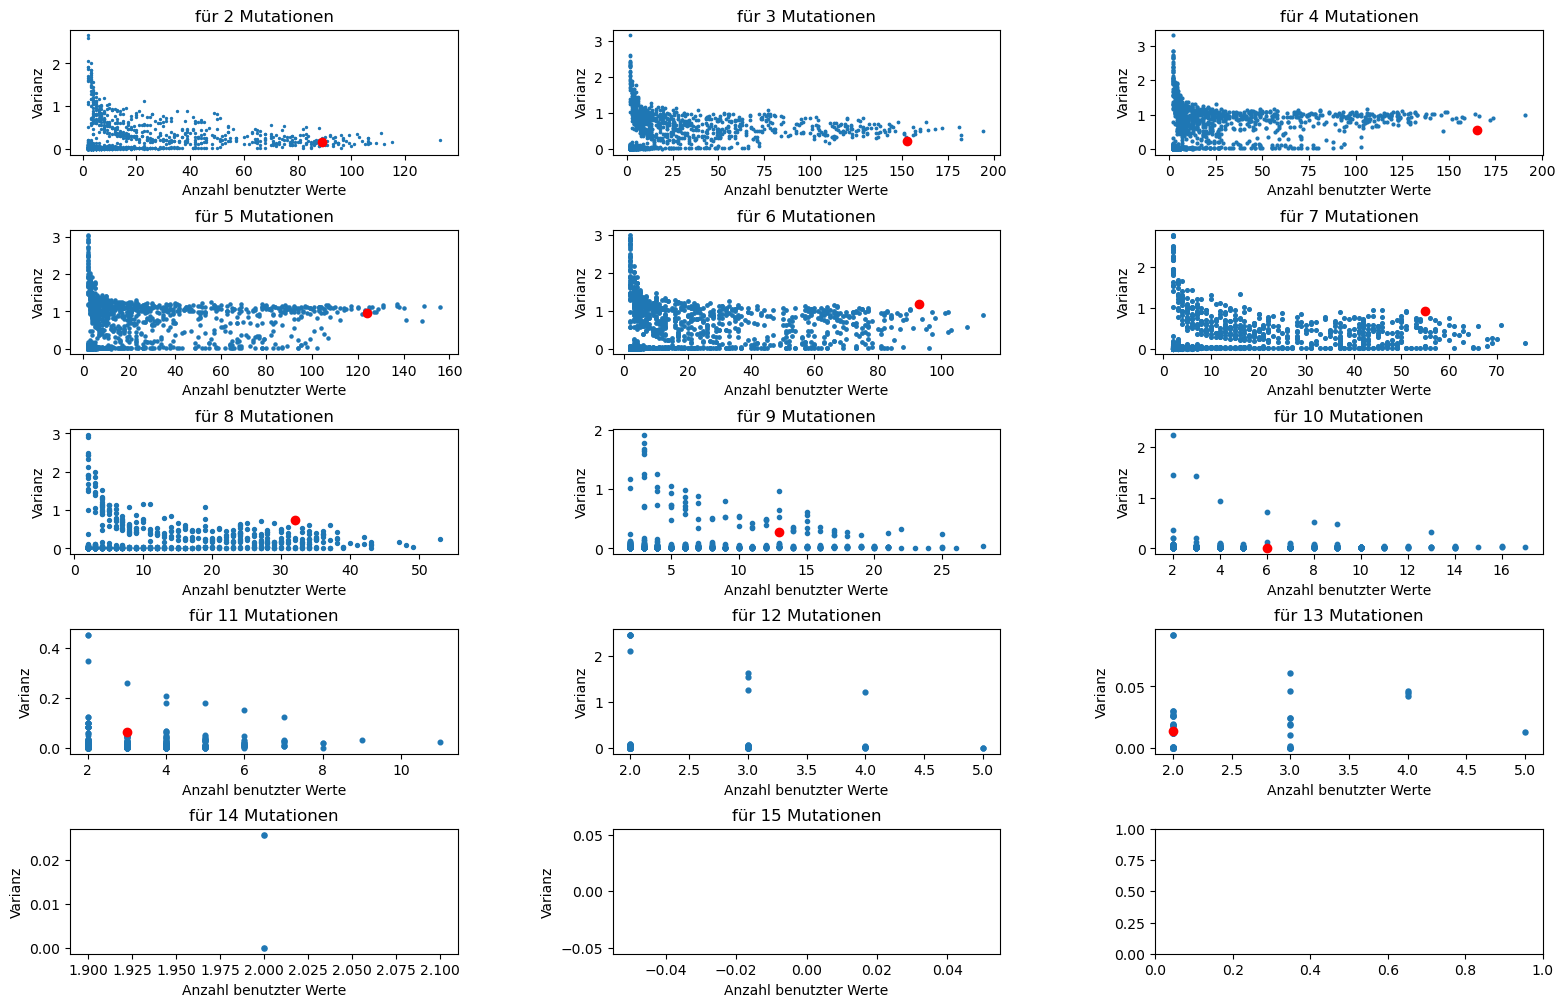

In [11]:
#verallgemeinert
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(19, 12))  # Abbildung und Achsenobjekte erstellen
plt.subplots_adjust(wspace=0.4, hspace=0.6)

for j, ax in zip(range(2, 16), axes.flatten()):
    variance_per_mutant_list = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        varianz_mut = fscore_mut.var()
        variance_per_mutant_list.append(varianz_mut)

    variance_per_mutant_series = pd.Series(variance_per_mutant_list, index=all_possible_mutations)
    variance_per_mutant_df = variance_per_mutant_series.to_frame()


#rausfinden wie viele Daten wir jeweils haben zum berechnen
    how_many_for_variance = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        wie_viel_jeweils = len(fscore_mut)
        how_many_for_variance.append(wie_viel_jeweils)

    how_many_for_variance = pd.Series(how_many_for_variance, index=all_possible_mutations)
    how_many_for_variance_df = how_many_for_variance.to_frame()


    how_many_AND_variance_df = pd.concat([how_many_for_variance_df, variance_per_mutant_df], axis = 1)
    how_many_AND_variance_df.columns = ['Anzahl benutzter Werte', 'Varianz']
    how_many_AND_variance_df = how_many_AND_variance_df.dropna()

#scatter plot erstellen, mit benennungen
    ax.scatter(how_many_AND_variance_df['Anzahl benutzter Werte'],how_many_AND_variance_df['Varianz'], s = j )
    ax.set_xlabel('Anzahl benutzter Werte')
    ax.set_ylabel('Varianz')

    if "V163A" in how_many_AND_variance_df.index:
        ax.scatter(how_many_AND_variance_df['Anzahl benutzter Werte']['V163A'],how_many_AND_variance_df['Varianz']['V163A'], c='red')
    ax.set_title(f'für {j} Mutationen')
# Diagramm anzeigen

plt.show()


1. Werte pro Mutation mitteln (mittel über Anzahl der Daten und Mittel über Varianz) und die dann ranken

In [12]:
#Varianzen mitteln für jede Mutation, über die Mutationscounts hinweg
frame_zum_mitteln_variance = pd.DataFrame(index = all_possible_mutations)
variance_per_mutant_count_list = []

# ACHTUNG: es werden nur counts von 2 bis 7 einbezogen weil die mit mehr sowieso "kaputt" sind!!!
for j, ax in zip(range(2, 8), axes.flatten()):
    variance_per_mutant_list = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        varianz_mut = fscore_mut.var()  #die varianz je mutation je anzahl
        variance_per_mutant_list.append(varianz_mut) #liste der Varianzen ALLER Mutationen je anzahl

    variance_per_mutant_df = pd.DataFrame(variance_per_mutant_list, index=all_possible_mutations)
    variance_per_mutant_count_list.append(variance_per_mutant_df)
variance_per_mutant_count_df = pd.concat(variance_per_mutant_count_list, axis=1)
variance_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)

# Varianz je Mutation je Mutationanzahl
variance_per_mutant_count_df
# dataframe mit allen varianzen (Zellen) pro alle mutationen (rows) pro alle counts (columns)

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_2045/3111823606.py:18: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  variance_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)


,2,3,4,5,6,7
M78K,0.700406,0.843154,0.939133,0.168586,0.123462,0.026544
Y145L,NaN,NaN,NaN,NaN,NaN,NaN
M153R,0.014569,0.272612,0.871961,0.960818,0.608533,0.018809
I123L,0.704050,0.009240,1.158941,0.002145,0.016149,0.014842
N159V,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
T108I,0.006535,0.843870,0.476773,0.731221,0.023476,0.019991
D180G,0.190975,0.834304,1.042040,0.861956,0.422935,0.021988
N185G,NaN,NaN,NaN,0.020005,NaN,NaN
G116S,0.010998,0.314992,1.208732,1.105029,1.204368,0.046531


-> 15 gibt es keine zwei Mutationen die sich in einer Mutation überschneiden -> keine Werte

In [13]:
mean_variances_per_mutations = pd.DataFrame(variance_per_mutant_count_df.mean(axis=1, skipna=True), columns=['Mean'])


In [14]:
how_many_per_mutant_count_list = []

for j, ax in zip(range(2, 8), axes.flatten()):
    how_many_for_variance = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        wie_viel_jeweils = len(fscore_mut)
        how_many_for_variance.append(wie_viel_jeweils)

    how_many_per_mutant_df = pd.DataFrame(how_many_for_variance, index=all_possible_mutations)
    how_many_per_mutant_count_list.append(how_many_per_mutant_df)
how_many_per_mutant_count_df = pd.concat(how_many_per_mutant_count_list, axis=1)
how_many_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)

# Varianz je Mutation je Mutationanzahl


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_2045/913872904.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  how_many_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)


In [15]:
mean_how_many_per_mutations = pd.DataFrame(how_many_per_mutant_count_df.mean(axis=1, skipna=True), columns=['Mean'])


WEITERES VORGEHEN MIT DIESEM CODE:
--> irgendwie mit einberechnen ob die Muts positiv oder negativ stabilisierend sind
--> negativ stabilisierenden rauskürzen
--> hoffentlich Ranking das besser passt

an einem bsp zuerst (V163A)
1. fscore mean von allen Mutanten mit b = mutcount und die V163A beinhalten
2. fscore mean von allen Mutanten mit b = mutcount und NICHT V163A beinhalten

In [16]:
index_wann_V163A = result_how_often.loc[result_how_often["V163A"] == True].index

only_V163A_muts = working_dataframe[(working_dataframe['mut_count'] > 2) & (working_dataframe.index.isin(index_wann_V163A))]

# Calculate the mean of DMS_score for the filtered rows
mean_dms_score_only_V163A = only_V163A_muts['DMS_score'].mean()
mean_dms_score_only_V163A

2.9222414515274346

In [17]:
index_wann_nicht_V163A = result_how_often.loc[result_how_often["V163A"] == False].index

not_V163A_muts = working_dataframe[(working_dataframe['mut_count'] >2) & (working_dataframe.index.isin(index_wann_nicht_V163A))]

# Calculate the mean of DMS_score for the filtered rows
mean_dms_score_not_V163A = not_V163A_muts['DMS_score'].mean()
mean_dms_score_not_V163A

2.394658303583483

--> fscore ist MIT V163A im Durchschnitt höher als ohne
--> passt
--> verifizieren mit deletierender Mutation (Y66C, sollte eigentlich sehr negativ sein)

In [18]:
index_wann_Y66C = result_how_often.loc[result_how_often["Y66C"] == True].index

only_Y66C_muts = working_dataframe[(working_dataframe['mut_count'] >2) & (working_dataframe.index.isin(index_wann_Y66C))]

# Calculate the mean of DMS_score for the filtered rows
mean_dms_score_only_Y66C = only_Y66C_muts['DMS_score'].mean()
mean_dms_score_only_Y66C


1.4026376283464594

In [19]:
index_wann_nicht_Y66C = result_how_often.loc[result_how_often["Y66C"] == False].index

not_Y66C_muts = working_dataframe[(working_dataframe['mut_count'] >2) & (working_dataframe.index.isin(index_wann_nicht_Y66C))]

# Calculate the mean of DMS_score for the filtered rows
mean_dms_score_not_Y66C = not_Y66C_muts['DMS_score'].mean()
mean_dms_score_not_Y66C

2.4092337636261

--> passt perfekt von den Werten her!

-> JETZT:
1. Differenz bilden als Messwert (!Vorzeichen) -> ein Wert pro Mutation
2. loopen für alle möglichen Mutationen -> Wert als Reihe untendranhängen


In [20]:
nur_fscore_mut_count = working_dataframe.loc[:, ["DMS_score", "mut_count"]]
nur_fscore_mut_count

,DMS_score,mut_count
0,1.301030,7
1,3.137350,4
2,1.553913,5
3,3.404237,3
4,3.738586,1
...,...,...
51709,3.809468,1
51710,3.760217,1
51711,3.754101,1
51712,3.673173,1


In [21]:
differences_list = []

for i in all_possible_mutations:
    index_when_mut_present = result_how_often.loc[result_how_often[i] == True].index

    only_rows_with_mut = nur_fscore_mut_count [(nur_fscore_mut_count ['mut_count'] >2) & (nur_fscore_mut_count .index.isin(index_when_mut_present))]

# Calculate the mean of DMS_score for the filtered rows
    mean_dms_score_only_mut = only_rows_with_mut['DMS_score'].mean()
#-------------
    index_when_not_mut_present = result_how_often.loc[result_how_often[i] == False].index

    only_rows_withOUT_mut = working_dataframe[(working_dataframe['mut_count'] >2) & (working_dataframe.index.isin(index_when_not_mut_present))]

# Calculate the mean of DMS_score for the filtered rows
    mean_dms_score_every_but_mut = only_rows_withOUT_mut['DMS_score'].mean()
#----------------
    difference_means = mean_dms_score_only_mut - mean_dms_score_every_but_mut
    differences_list.append(difference_means)

all_differences_means = pd.DataFrame({'Difference': differences_list}, index=all_possible_mutations)
print(all_differences_means)

       Difference
M78K    -0.616111
Y145L    0.587012
M153R    0.114269
I123L   -0.285338
N159V         NaN
...           ...
T108I   -0.878622
D180G   -0.271794
N185G   -0.816531
G116S   -0.085721
H217D   -1.086085

[1810 rows x 1 columns]


In [22]:
condition = all_differences_means['Difference'] > 0

# Anzahl der Zeilen, auf die die Bedingung zutrifft
num_rows_matching_condition = len(all_differences_means[condition])
num_rows_matching_condition

674

In [23]:
frame_zum_mitteln_variance = pd.DataFrame(index = all_possible_mutations)
variance_per_mutant_count_list = []

# ACHTUNG: es werden nur counts von 2 bis 7 einbezogen weil die mit mehr sowieso "kaputt" sind!!!
for j, ax in zip(range(2, 8), axes.flatten()):
    variance_per_mutant_list = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        varianz_mut = fscore_mut.var()  #die varianz je mutation je anzahl
        variance_per_mutant_list.append(varianz_mut) #liste der Varianzen ALLER Mutationen je anzahl

    variance_per_mutant_df = pd.DataFrame(variance_per_mutant_list, index=all_possible_mutations)
    variance_per_mutant_count_list.append(variance_per_mutant_df)
variance_per_mutant_count_df = pd.concat(variance_per_mutant_count_list, axis=1)
variance_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)
mean_variances_per_mutations = pd.DataFrame(variance_per_mutant_count_df.mean(axis=1, skipna=True), columns=['Mean'])

#----------------------

how_many_per_mutant_count_list = []

for j, ax in zip(range(2, 8), axes.flatten()):
    how_many_for_variance = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        wie_viel_jeweils = len(fscore_mut)
        how_many_for_variance.append(wie_viel_jeweils)

    how_many_per_mutant_df = pd.DataFrame(how_many_for_variance, index=all_possible_mutations)
    how_many_per_mutant_count_list.append(how_many_per_mutant_df)
how_many_per_mutant_count_df = pd.concat(how_many_per_mutant_count_list, axis=1)
how_many_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)
mean_how_many_per_mutations = pd.DataFrame(how_many_per_mutant_count_df.mean(axis=1, skipna=True), columns=['Mean'])


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_2045/3151573331.py:17: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  variance_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)
/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_2045/3151573331.py:36: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  how_many_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)


In [24]:
list_wie_oft_mut = []
for j in all_possible_mutations:
    matching_indexes = result_how_often.loc[result_how_often[j] == True].index
    wie_oft = len(matching_indexes)
    list_wie_oft_mut.append(wie_oft)
df_wie_oft_muts_insg = pd.DataFrame(list_wie_oft_mut, index=all_possible_mutations)
df_wie_oft_muts_insg

,0
M78K,142
Y145L,5
M153R,53
I123L,24
N159V,2
...,...
T108I,47
D180G,396
N185G,8
G116S,63


In [25]:
abc = all_differences_means.loc['K166Q']
print(abc)
cde = df_wie_oft_muts_insg.loc['K166Q']
print(cde)

Difference    0.431317
Name: K166Q, dtype: float64
0    64
Name: K166Q, dtype: int64


In [26]:

#code für ranking aus anderem dokument aber mit den sachen von oben berücksichtigt, alle destab raus
combined_differenz_wie_oft_mut= pd.concat([all_differences_means, df_wie_oft_muts_insg], axis=1)
combined_differenz_wie_oft_mut.columns = ['Difference', 'wie oft kommt mut insg vor']

threshold = 200

condition = combined_differenz_wie_oft_mut['wie oft kommt mut insg vor'] < threshold
sorted_df_with_treshold = combined_differenz_wie_oft_mut.drop(combined_differenz_wie_oft_mut.loc[condition].index)

# Ausgabe des aktualisierten DataFrames
sorted_combined_differenz_wie_oft_mut = sorted_df_with_treshold.sort_values(by='Difference', ascending= False)

#alle destabilisierenden rausnehmen
destab_rausnehmen_indeces = sorted_combined_differenz_wie_oft_mut.loc[all_differences_means['Difference'] < 0].index
ranking_without_destab = sorted_combined_differenz_wie_oft_mut.drop(destab_rausnehmen_indeces)
# Ausgabe des sortierten DataFrames

TOP_MUTANTS = ['V163A', 'K166Q', 'V68M', 'E172A', 'A206V', 'T43N', 'H25Q', 'S205T', 'E6K', 'T62S', 'I171V', 'T203I', 'Y39N', 'E111V', 'E32A']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking_without_destab = ranking_without_destab.style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('formatted_ranking_without_destab.html', 'w') as file:
    file.write(styled_ranking_without_destab.render())


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_2045/681567410.py:30: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking_without_destab.render())


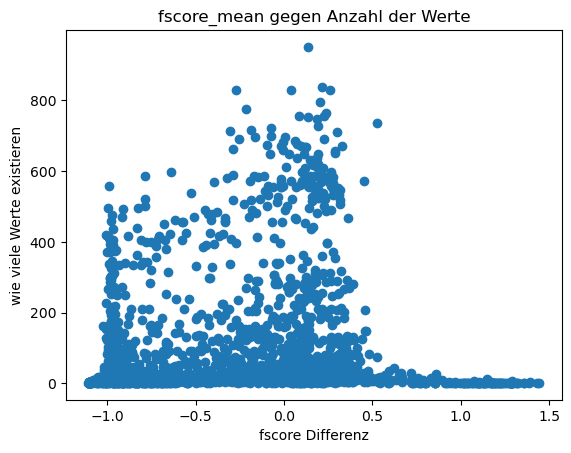

In [27]:
plt.plot(combined_differenz_wie_oft_mut['Difference'],combined_differenz_wie_oft_mut['wie oft kommt mut insg vor'], 'o')
plt.xlabel('fscore Differenz')
plt.ylabel('wie viele Werte existieren')
plt.title('fscore_mean gegen Anzahl der Werte')

plt.show()

PLAN Weiterhin:
1. Ranking stabiler machen durch normieren/gewichten durch VArianz (?)
2. neues Ranking (2)

In [29]:
# Gewichtung basierend auf der Anzahl der Mutationen
weighted_differences = all_differences_means['Difference'] * df_wie_oft_muts_insg[0]

# Erstellung eines gewichteten DataFrame
weighted_ranking = pd.DataFrame({'Weighted Difference': weighted_differences}, index=all_possible_mutations)

# Sortierung des gewichteten DataFrames
sorted_weighted_ranking = weighted_ranking.sort_values(by='Weighted Difference', ascending=False)
sorted_weighted_ranking

,Weighted Difference
V163A,388.828780
I171V,257.867360
S175G,219.571456
K113R,216.440643
I167V,212.858116
...,...
V16T,NaN
F99N,NaN
K79V,NaN
E6R,NaN
